# Trees?

Tree based methods are extremely powerful methods for regression problems (where we are trying to estimate a value form an input, e.g. estimate band gap energy for a material) and classification problems (where we are trying to classify an input into several classes, e.g. classify material as metal/non-metal).

Trees partition the feature space into a set of rectangles and then fit a simple model (like a constant) in each partition. That's a mouthful. We'll go over the theory of trees in this tutorial to help you understand that sentence as we look at several examples. We start off with a toy example and then consider classifying materials as metal/non-metal and then finish off with a regression problem where we predict a compound's volume per atom. We revisit these two problems with random forests and a bagging classfier.

I will assume for this tutorial you have no exposure to trees and small exposure to Python. Feel free to skip ahead any sections where you feel like you know the material. Instead of inundating you with equations and facts about trees we'll instead dive into a simple problem and explain as we go a long.

# Outline

In this tutorial you will learn:

1. [Basics of trees - toy model](#toy_model) 
    1. [Tree terminology](#tree_terminology)
    2. [Decision Boundaries](#decision_boundary)
    3. [How to estimate class probabilities](#class_prob)
    4. [Classify a region](#classify_region)
    4. [Classification Metrics](#class_metrics)
        1. [Misclassification error](#miss_error)
        2. [Gini index](#gini)
    5. [Algorithm to build a tree](#classification_alg)
2. [Classifying compounds at Metal/Non-Metal](#classify_metals)
    1. [Discuss data](#discuss_metal_data)
    1. [Split data into test/train](#splitting_data)
    2. [Train classifier](#train_classifier)
    3. [Plot learning curves](#learning_curve)
    4. [No scaling/centering required](#no_scaling)
3. [Regression Trees](#regression_trees)
    1. [Choose constant estimate of region](#choosing_constants)
    2. [Find best binary partition](#best_partition)
    3. [Train regressor](#train_regressor)
3. [Ensemble Methods Theory](#ensemble_methods_theory)
4. [Random Forests](#random_forests)
5. [Cross-validation, hyper-parameter search](#random_forests)
    1. [Grid search](#grid_search)
6. [Feature Importance in Random Forests](#feature_importance)
6. [Bagging classifier](#bagging_classifier)
7. [Impotant topics not covered](#important_topics_not_covered)

The tutorial is quite long so don't feel pressured to finish it in one sitting.


# Quick Tidbit About Very Useful Resources
This tutorial is largely based off two fantastic sources for statistical learning. The textbook *The Elements of Machine Learning* by Prof. Friedman, Prof. Hastie and Prof. Tbishirani. I can't sing the praise of the professors enough. They are key leaders in the applied statistics/machine learning methods. The textbook is the bible of statistical learning. The book is accessible thanks to Prof. Hastie [here](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

The other textbook is called * Hands-On Machine Learning with Scikit-Learn and TensorFlow* by Aurelion Geron. Aurelion, who worked many years at Google, is so good at making the subject accessible to those without a strong statistics/math background. He also made the code for the book accessible. A PDF of Aurelion's textbook is accessible [here](https://www.lpsm.paris/pageperso/has/source/Hand-on-ML.pdf) courtesy of the Laboratory of Probability, Statistics and Modelling in Paris.


<a id='toy_model'></a>
## Visualizing Trees - An Introductory Example

We'll start with the problem of classifying different flowers, specifically trying to classify flowers called irises. This [dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) is very well known in the statistics community. It was provided by British statistician Ronald Fisher who is well known for his contributions to maximum-likelihood estimation, linear discriminant analysis, ANOVA, and many other important fields (unfortunately, Dr. Fisher is also well known for having been a racist and proponent of Eugenics).

Back to the problem at hand - Trees - the iris dataset we will use is easily loaded using [SciKit](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) Learn's API. Scikit has the following useful information for us - "the dataset consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray. The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width".

So let's take the momentous first step of our journey - let's load the data.

In [1]:
# We import a method to load the dataset from SciKit Learn (SKlearn).
from sklearn.datasets import load_iris
iris = load_iris()

Great, now we have our data in an object named iris. What is an [object](https://docs.oracle.com/javase/tutorial/java/concepts/object.html)? Objects are containers that hold data and methods. We are most interested in the data in this object. We can access the data by typing - object.data - where the period after the object let's us know we want to access one of the object's member variables (specifically its data in our case). So for an object named iris, we want to type - iris.data - to access its data. The data in iris.data is a numpy array.

What is [numpy](https://numpy.org/) you ask? It was developed as an open source effort to create commonly used numerical methods/functions in a simple package you can import. Python is not a very fast programming language. It is a high-level language that allows you to make use of abstractions (an object is an example of a useful abstraction, since an object is something that can bundle methods and data together). Numpy is a package we load into python. Numpy's methods are written at the core in a low-level programing language called C that makes the code run very fast.

So the data is stored in an 2-dimensional array (matrix) with 150 rows (for each datapoint) and 4 columns specifying the type or iris flower, the petal length, petal width and sepal length.

Wait what is a sepal? Courtesy of wikipedia commons we can visualize what a petal and sepal are for a flower. Let's display an image now.


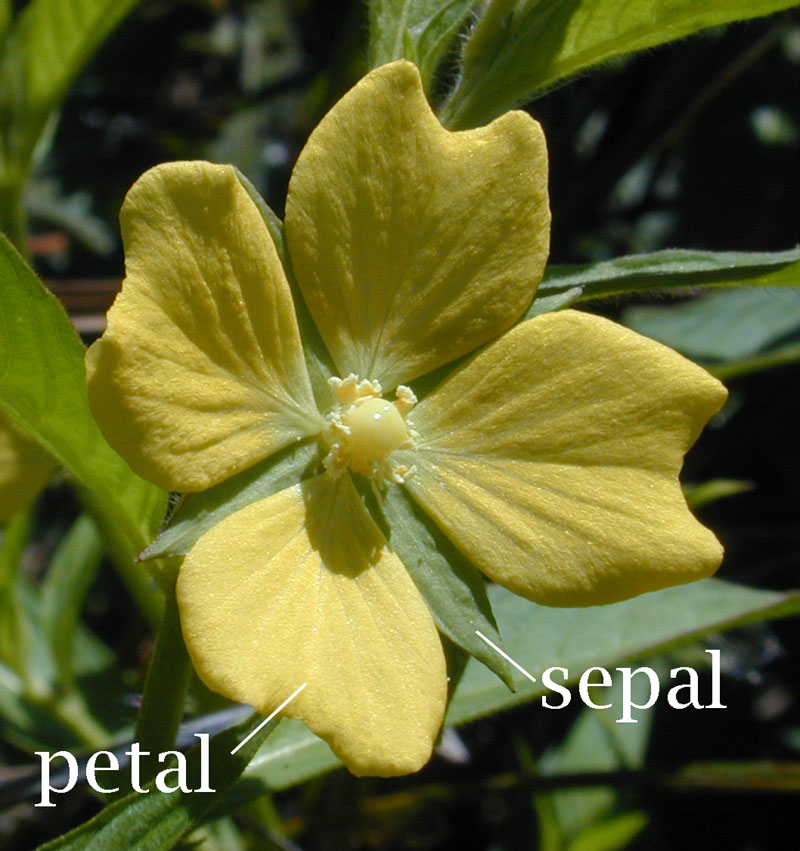

In [2]:
# Import method to display images in Jupyter Notebook.
from IPython.display import Image
# Display image by calling display method with image filename as input.
Image(filename='./assets/decision_tree/Petal-sepal.jpg', width=200)

Ok, so we have an understanding for what our descriptors (petal width/length, sepal length) are and what are target is (classify the flower as either Setosa, Versicolour, or Virginica).

Great now, let's take a quick peek at what data types are used by SKLearn.

In [3]:
# What type is the iris dataset object?
type(iris)

sklearn.utils.Bunch

In [4]:
# We can aslo see what the type of the iris's object data memeber.
type(iris.data)

numpy.ndarray

In [5]:
# Let's create an alias for iris.data. We assign this data to variable called
# data_matrix. The data_matrix variable will also be a numpy array.
data_matrix = iris.data

Let's build our first model on only two of the descriptors, namely, petal length and width. We create a new matrix that is assigned with two columns (the last two) of the $data\_matrix$ variable. We'll call this new variable the descriptor matrix. We'll also make use of python indexing. A numpy matrix, named numpy_matrix, value for row $i$ and column $j$ can be accessed using $data\_matrix[i, j]$. If we want a row from this matrix we specify $data\_matrix[0, :]$. The $0$ in the first index means we want the first row. Note, python indexing begins at $0$ not at $1$. The $:$ in the second index means we want all columns corresponding to the first index. Similarly, if we would want the 3rd column we would specify $data\_matrix[:, 2]$.

Here, we want to include the third and fourth columns as our descriptors. To do so we make use of another indexing trick. To get all columns from the third to the last column (so all columns except first three) we can write $data\_matrix[:,2:]$. The $2:$ specifies we want columns $2$ until the end of the matrix (until and including the last column).

So we create a new predictor matrix with the same amount of rows as the numpy data matrix but with only columns $3$ and $4$.

In [6]:
predictor_matrix = data_matrix[:, 2:]

In [7]:
# Now we can make use of the iris object by accessing its 'target'
# member variable.
target = iris.target

<a id='train_command'></a>
Time to build our first tree. We load the decision tree class from SkLearn and fit our model by providing the descriptors and target.

What is a [class](https://docs.oracle.com/javase/tutorial/java/concepts/class.html) you ask? A class is a blueprint to build objects. The [decision tree classifier class](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) from SkLearn will help us build objects that have methods to build and fit decision trees that map our input predictors to our target.

The tree is then built and we can analyze the tree to understand the question we set out to ask - what are decision tree models?

In [8]:
# Import class that will help us build/fit trees.
from sklearn.tree import DecisionTreeClassifier
# We create a decision tree classifier object.
# We also specify a parameter called max_depth when we create this
# object. We'll discuss what this parameter does in a few moments.
# The other parameter random state gives a seed to the classifier
# which means any it will use the same starting point in the algorithm.
tree_classifier = DecisionTreeClassifier(max_depth=2, random_state=0)
# Now we fit out model. We tell our object we want to build the
# best tree (we'll talk about what best really means in a few moments too)
# possible to map our input variables to our target.
# In the fit method() we have to specify our X (predictor) matrix
# and our y (target).
tree_classifier.fit(X=predictor_matrix, y=target)
# The output we see shows out the object and some of the many parameters it
# has which we'll talk about soon.

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Now that we've built our first tree model and trained it on this iris dataset. Let's see what it looks like. To do so we make use of a [graphviz](https://www.graphviz.org/) which is a graphical visualization software that is open source. We will export our Sklearn tree object to graphviz so that we can visualize the decision tree.

In [9]:
# Import method to export our tree object to graphviz.
from sklearn.tree import export_graphviz
# Let's give a filename to what we want the visualized tree to have.
# filenames in python are always strings so we assign a string.
filename = 'data/decision_tree/iris_tree_classifier'
# Export our tree classifier object to graphviz. We also feed in
# the feature/descriptor names and target name and specify we
# want numbers shown to be rounded. We specify we want to save the
# file as a .dot file which is a type native to graphviz.
export_graphviz(
    tree_classifier, out_file=filename + '.dot',
    feature_names=iris.feature_names[2:], class_names=iris.target_names,
    rounded=True, filled=True)

We've exported our tree classifier to a graphviz type dot file. But we want an image file so we'll use graphviz to convert this into a .png type image we can display. The command to do that is a linux command (not a python line of code). But we can use the python package subprocess to run the linux command with a python line of code.

In [10]:
# Import method to run linux commands using a python method called call().
from subprocess import call
# Wrap the linux command in the python call() method. Here we specify that
# we want to use the graphviz package to convert our file from a .dot type
# to a .png type.
call(['dot', '-Tpng', filename + '.dot', '-o', filename + '.png'])
# The zero in the output means we didn't have any errors in the conversion.

0

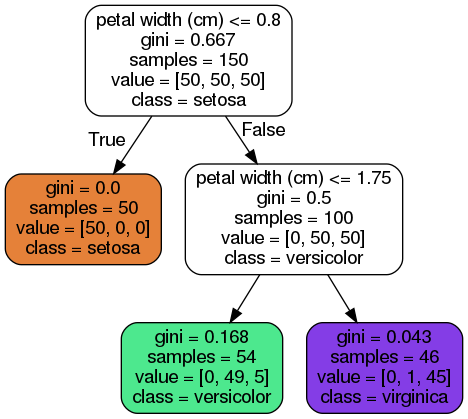

In [11]:
# Display image by calling display method with image filename as input.
Image(filename=filename + '.png')

<a id='tree_structure_plot'></a>
Amazing, you've built your first decision tree and visualized it. Let's try to decipher what we're seeing here. Let's go through some tree terminology.

<a id='tree_terminology'></a>
## Tree Terminology

Node/Vertex: A node in a tree is the bubble's you're seeing with gini, samples, value and class values given.

Leaf: A leaf node is any node at the bottom (vertically) of the tree. We call it a leaf because it is the outer extremity of the tree.

Root: The (there can only be one for a single tree) root node is the node at the top (vertically) of the of the tree.

Branch/Edge: A branch in a tree is the line that connects two nodes.

Child/Parent: A child node is a node which has a branch between it and it's parent node. The parent node must be vertically above the child node. You notice in the visualization the branch/edge is an arrow with a downwards direction. This is because we read trees from top to bottom. So in our case the root node has no parents, but has two children.

Depth: How many levels down are you from the root node. The root node is at 0 depth. The child of the root node on the left has depth of 1.

<a id='decision_boundary'></a>
## Understanding Trees - Decision Boundaries

Alright, now we have the right terms to use. Let's try to make sense of this tree. We start analyzing the tree from top to bottom. Which means we start at the *root* node. This is where we start our classification/prediction. We ask ourselves, does the iris flower have petal width (cm) greater than 0.8 cm? If true move to the left child of the root node if false move to the right child of the root node. Imagine the iris flower we are trying to classify does have a petal width greater than or equal to 0.8 cm then we end up on the left child of the root node which is a leaf node. If we reach a leaf node we are done with our classification and we can just read the classification from this node which in our case tell us to classify this iris flower as a setosa.

What about if the petal width was not greater than 0.8 cm. In that case we move to the right child of the root node. The right child is not another node but again another question for us to answer. Is the petal width less than or equal to 1.75 cm? If true we move to the left child of this node if not we move to the right child of this node. Both of those options bring us to leaves where we will classify the flower as either versicolor (if petal width is less than or equal to 1.75 cm) or virginica (if the petal width is greater than 1.75 cm).

Now that you understand some of the mechanics of how to interpret a trained tree classifier to make predictions. Let's visualize this trained tree in another way. Since we only have two input variables petal width/length we can make a simple two dimensional plot showing the decision boundaries.

We will make use of a method developed by Aurelion Geron. He is a fantastic programmer.

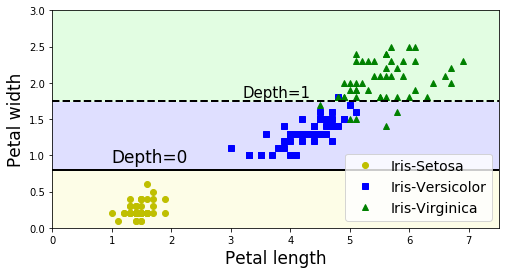

In [12]:
# We don't need to understand this method to understand trees.
# Just know it is a useful tool to plot decision tree boundaries.
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(
    clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=True, plot_training=True):
    """Method developed by Aurelion Geron"""
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=17)
        plt.ylabel("Petal width", fontsize=17)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

# Some commands Aurelion developed to make the plot look pretty.
# We've adapted them for our model.
plt.figure(figsize=(8, 4))
plt.tight_layout()
plot_decision_boundary(tree_classifier, predictor_matrix, target)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)

plt.text(1.0, 0.9, "Depth=0", fontsize=17)
plt.text(3.2, 1.80, "Depth=1", fontsize=15)

# Show the figure
plt.show()


In this plot we can see where the tree makes its decisions. This very simple tree seems to do a good job at least visually. We separate the setosa iris flowers completely from the other flowers simply by classifying based on whether petal width is larger or less than 0.85. The tree doesn't do as well in classifying the virginica and versicolor iris flowers. We can see from the two dimensional plot that this is not an easy task as it would be hard to draw a border between the two types of flowers. This suggests we need another feature maybe sepal width to help us separate these two flowers. We'll try that next.

We also note that only one feature has been used in making the tree. Namely the petal width. The petal length has not been used.

<a id='class_prob'></a>
## Estimating Class Probabilities

There you have it. We've classified the flowers we've set out to do. But wait! How good have we actually done with our trained decision tree classifier model? To answer this question we need to put our math hats on.

So we've seen that a tree partitions the input space into rectangles. The tree we visualized earlier gives us a prediction for each rectangle. It also can give us something very valuable a class probability prediction.

For instance, in our tree at the leaf node we end up with 49 iris-virginica training samples and 4 iris-versicolor training samples. We could estimate at this leaf node that the probability that a datapoint that ends up by following the tree downwards in this rectangle is versicolor is simply by counting the proportion of versicolor training samples in this node.

So a formula for the estimated probability for class $k$ for a node $m$ representing a region $R_{m}$ with $N_{m}$ observations:

$$\hat p_{mk}=\frac{1}{N_{m}} \sum \limits _{x \in R_{m}} I(y_{i} = k)$$

Note the capital $I$ is similar to the kronecker delta we all know and love, it is $1$ if $y_{i} = k$ and zero otherwise. Intuitively, we note that if there are many samples in the region represented by the node $m$, $R_{m}$ of a certain class $k$ we should expect the probability that any sample found in this region will be class $k$ will be high. This formula agrees.

Going back to our iris-flower example in the decision boundary plot we note that for petal width < 0.85 we have only one type of flower, the setosa. The estimated probability that a sample found in this region is setosa is therefore 100%.

Using this definition we can predict what is the probability a datapoint (one we haven't seen) belongs to a certain class. So what is the probability a iris flower with petal width 2 cm and petal length 4.3 cm belongs to a class?

In [13]:
petal_length = 4.3
petal_width = 2 
tree_classifier.predict_proba([[petal_length, petal_width]])

array([[0.        , 0.02173913, 0.97826087]])

The output tells us we estimate zero probability the flower belongs to setosa, 2% estimated chance it belongs to versicolor and 98% chance it belongs to virginica.

<a id='classify_region'></a>
## Classifying a Region

Armed with this definition of estimated class probability we can understand how we classify the region of a leaf node $m$. We classify the observations in node m to class k by looking which class probability is largest in $R_{m}$, the region represented by node m. Or, in math:

$$ k(m) = \text{argmax}_{k}\hat p_{mk} $$

of a region in our tree we can now start to quantitatively say when a tree does a good job. It should ideally separate all classes completely and therefore it should estimate class probabilities of either 100% or 0%. Obviously, some datasets are not separable, so we need a better definition of what we're trying to optimize when we build a tree. We're really trying here to measure the node's impurity.

<a id='mis_error'></a>
### Misclassification Error
We can quantify the node $m$'s impurity using what is called the misclassification error.

$$ \frac{1}{N_{m}} \sum \limits _{x \in R_{m}} I(y_{i} \neq k(m)) = 1 - \hat p_{mk}$$

This is a simple fraction of the nodes in the region that are not of the most popular class. It gives us a simple intuitive way to quantify the impurity of the node and we get to use our class probability equation again.

<a id='gini'></a>
### Gini Index

More often, the [gini index](https://en.wikipedia.org/wiki/Gini_coefficient) is used to build classification trees. It is used by economists to measure income inequality. We sum from class $k$ = 1 to $K$ (the amount of classes in our classification problem, in our iris problem there are three types of flowers so three classes).

$$ \sum \limits _{k=1}^{K}  \hat p_{mk} (1 - \hat p_{mk})$$

So a good gini index would be a small number close to zero. We see in our tree we built for the most part we have good gini indices close to zero.

With this knowledge we can look back at the [image](#tree_structure_plot) displaying our tree structure and understand what was shown to us. A node's value attribute tells us how many data points of each class end up in this node. So for the left child of the root, we see the node applies to 50 setosa flowers and zero other types. Therefore it has a gini index of 0.

**Challenge**: train a new tree using command [here](#train_command), but this time let the tree grow tree to a larger depth (try a depth of $4$) and see if the gini index improves. This time you can understand why the class DecisionTreeClassifier has a parameter called creiterion whose default is set to 'gini'. The tree is minimizes the gini index of regions by making splits.

<a id='classification_alg'></a>
## Training Algorithm CART

The Classification and Regression Tree (CART) algorithm developed by Prof. Friedman et al in 1983 is often used to train trees. It creates trees that have at most two children. Note there are other algorithms that allow for more than two children but they are used less often.

The idea with training a tree is that we create a first decision split in our data and then continue to make finer sub-partitions to our initial partition. In this way, we can thinking of training our regression tree as if we are growing the tree.

How do we choose this first split? The idea is that we use a cost function $J$ that has as inputs the class we are splitting on, $k$, and the decision boundary threshold $t_{k}$ which depends on the class. The cost function seeks to minimize the impurity in the children that arise from the split. We want the purest children. If we choose the gini index, $G$ to measure our impurity the cost function becomes: 

$$J(k, t_{k}) = \frac{n_{left}}{N} G_{left} + \frac{n_{right}}{N} G_{right}$$

Here, $\frac{n_{left}}{N}$ is the fraction of instances in the left child/partition. Similarly for
$\frac{n_{right}}{N}$ it is the fraction of instances/data points that end up in the right child/partition. $G_{left}$ measures the gini index of the left child (left partition), $G_{right}$ measures the gini index of the right child (right partition).

So our optimization problem is then to find the class, $k$, and threshold, $t_{k}$, that minimizes our cost function. After having done the first partition we follow the same procedure and look for the class and threshold that minimizes our cost function in the sub-partitions created after the first partition. We continue to grow our tree until we reach the maximum depth we've specified.

<a id='classify_metals'></a>
# Classification of Materials as Metal/Non-Metal

Now that we've understood how trees maximize the purity of partitions they create we know have the tools to approach more difficult problems than our toy model iris-dataset.

Let's try to classify VASP DFT-data from the [Materials Project](https://materialsproject.org/). More about the dataset and other can be found [here](https://hackingmaterials.lbl.gov/matminer/dataset_summary.html). The data can also be pulled from NOMAD. 

Andreas has done the data engineering work already and the data has been nicely parsed and is lying around in a [pandas](https://pandas.pydata.org/) dataframe for us to use.

What is pandas? It's an open source software package for python that allows for easy manipulation of data in tabular format (rows, columns). Why do we need to learn about pandas when we already learned about numpy matrices? The two are synergetic. You can easily convert a pandas dataframe to a numpy matrix and vice versa. Pandas dataframe objects carry around more information (column names, row indices). The Pandas dataframe class also comes with its own methods that are very useful and that we'll use now to get comfortable with the dataset. 

In [14]:
# We import the pandas package and we import it
# as pd. Meaning we can refer to pandas' methods
# and classes simply by writing pd instead of pandas.
import pandas as pd
# The Materials Project data has been conveniently
# saved as a csv for us.
mat_proj_filename = 'data/decision_tree/Handson_metal_vs_nonmetal_data.csv'

# We read the data into a pandas
# dataframe. We use pandas read_csv() method on the filename.
dataframe = pd.read_csv(mat_proj_filename)

# Preview the first 5 lines of the loaded data 
dataframe.head()

compound  is_metal  rel_stoich_wa  rel_stoich_wad  atomic_volume_wa  \
0    K4Mn4O8     False       0.375000           0.375           22.0025   
1     Cr3Ni1      True       0.625000           0.500            7.0700   
2  Cs1Rb1As1      True       0.333333           0.000           46.5500   
3     Si1Sn1     False       0.500000           0.000           14.1750   
4      Ca3P2     False       0.520000           0.200           22.5280   

   atomic_volume_wad  atomic_rs_max_wa  atomic_rs_max_wad  atomic_rp_max_wa  \
0            43.2325      8.652500e-11       2.127550e-10      1.479100e-10   
1             0.6400      1.368825e-10       1.711000e-11      1.869150e-10   
2            67.2000      1.851333e-10       2.002667e-10      2.470667e-10   
3             4.2300      9.992500e-11       1.221000e-11      1.239950e-10   
4             9.1800      1.387040e-10       9.314000e-11      1.781340e-10   

   atomic_rp_max_wad  atomic_rd_max_wa  atomic_rd_max_wad  atomic_number_wa  \
0       3.146700e-10      2.027775e-10       9.961250e-11         15.000000   
1       4.290000e-11      4.119000e-11       1.008000e-11         25.000000   
2       2.854733e-10      1.537467e-10       2.572133e-10         41.666667   
3       2.087000e-11      2.662600e-10       4.386600e-10         32.000000   
4       1.357900e-10      1.229200e-10       1.372500e-10         18.000000   

   atomic_number_wad  atomic_ionization_potential_wa  \
0          21.000000                         9.74850   
1           4.000000                         6.98425   
2          26.666667                         5.96100   
3          36.000000                         7.74750   
4           5.000000                         7.85920   

   atomic_ionization_potential_wad  atomic_pauling_electronegativity_wa  \
0                          11.5845                             2.312500   
1                           0.8730                             1.722500   
2                           7.7060                             1.263333   
3                           0.8070                             1.930000   
4                           4.3680                             1.476000   

   atomic_pauling_electronegativity_wad  atomic_r_covalent_wa  \
0                              3.382500              1.185000   
1                              0.250000              1.352500   
2                              1.833333              1.943333   
3                              0.060000              1.250000   
4                              1.190000              1.484000   

   atomic_r_covalent_wad  
0               1.575000  
1               0.150000  
2               1.506667  
3               0.280000  
4               0.690000

So we note a few things. We have the column names on the top and row indices on the left. We have several columns of interest. The $compound$ which gives us a chemical formula. The $is\_metal$ column which tells us using a boolean whether the metal is $True$ or $False$.

Let's print all the column names out.

In [15]:
# We loop over every column that is inside
# dataframe object member variable columns
# which contains a list of column names.
for column in dataframe.columns:
    print(column)

compound
is_metal
rel_stoich_wa
rel_stoich_wad
atomic_volume_wa
atomic_volume_wad
atomic_rs_max_wa
atomic_rs_max_wad
atomic_rp_max_wa
atomic_rp_max_wad
atomic_rd_max_wa
atomic_rd_max_wad
atomic_number_wa
atomic_number_wad
atomic_ionization_potential_wa
atomic_ionization_potential_wad
atomic_pauling_electronegativity_wa
atomic_pauling_electronegativity_wad
atomic_r_covalent_wa
atomic_r_covalent_wad


<a id='discuss_metal_data'></a>
## Discuss Metal/Non-Metal Data

What are the columns referring to? Atomic volume weighted average is labelled as atomic_volume_wad. We also have atomic volume weighted average deviation labelled as atomic_volume_wa. We have relative stoichiometry (rel_stoich), we have maximum atomic radii for s orbitals (atomic_rs), p orbitals, ionization potentials, covalent radius for atomic species weighted average (atomic_r_covalent_wa).

What do the weighted average and weighted average deviation refer to? The mean and average deviation are calculated using the following formulae:

mean or weighted average (wa):
$$ \bar{f} = \sum \limits _{i} x_{i}f_{i}$$
weighted average deviation (wad)
$$ \hat{f} = \sum \limits _{i} x_{i} |f_{i} - \bar{f}| $$


where $ f_{i} $ is the property of the element ${i}$. $ x_{i} $ is the atomic fraction in compound.

Let's look at an example compound, iron oxide $F_{2}O_{3}$.

The weighted average in the atomic number is:

$ \frac{2}{5}* 26 + \frac{3}{5}*8 = 15.2 $

Similarly, for the weighted average deviation:

$ \frac{2}{5}|26 - 15.2| + \frac{3}{5}|8 - 15.2| = 15.2 $

Let's look at the dataframe a bit more closely using the describe() method that each dataframe object has. It shows us statistics of each column.

In [16]:
dataframe.describe()

rel_stoich_wa  rel_stoich_wad  atomic_volume_wa  atomic_volume_wad  \
count  106113.000000   106113.000000     106113.000000      106113.000000   
mean        0.442125        0.705545         15.832648          18.951830   
std         0.104404        0.403431          4.692029          15.886009   
min         0.156250        0.000000          4.390000           0.000000   
25%         0.375000        0.375000         13.315625           9.423750   
50%         0.422500        0.675556         15.362857          14.270000   
75%         0.500000        0.979592         17.528542          21.810000   
max         1.000000        2.731405         70.940000         120.636875   

       atomic_rs_max_wa  atomic_rs_max_wad  atomic_rp_max_wa  \
count      1.061130e+05       1.061130e+05      1.061130e+05   
mean       9.652791e-11       1.459470e-10      1.318759e-10   
std        2.858428e-11       7.643939e-11      4.326353e-11   
min        2.691000e-11       0.000000e+00      3.719000e-11   
25%        7.456250e-11       8.940000e-11      9.691154e-11   
50%        9.154400e-11       1.407920e-10      1.207283e-10   
75%        1.169286e-10       1.984300e-10      1.648107e-10   
max        2.462700e-10       5.457100e-10      3.207200e-10   

       atomic_rp_max_wad  atomic_rd_max_wa  atomic_rd_max_wad  \
count       1.061130e+05      1.061130e+05       1.061130e+05   
mean        2.261719e-10      1.974028e-10       4.257477e-10   
std         1.169563e-10      1.176637e-10       3.555795e-10   
min         0.000000e+00      2.274000e-11       0.000000e+00   
25%         1.367379e-10      1.192900e-10       1.478775e-10   
50%         2.228640e-10      1.823200e-10       2.920173e-10   
75%         3.026739e-10      2.480158e-10       6.876086e-10   
max         8.702655e-10      9.999900e-10       2.273750e-09   

       atomic_number_wa  atomic_number_wad  atomic_ionization_potential_wa  \
count     106113.000000      106113.000000                   106113.000000   
mean          25.738558          48.658420                        9.868168   
std           15.919089          27.933545                        2.129802   
min            1.000000           0.000000                        3.893000   
25%           12.700000          27.000000                        7.953333   
50%           21.500000          43.400000                       10.300600   
75%           35.000000          66.750000                       11.378500   
max           94.000000         192.423077                       17.420000   

       atomic_ionization_potential_wad  atomic_pauling_electronegativity_wa  \
count                    106113.000000                        106113.000000   
mean                          9.330699                             2.325430   
std                           5.953760                             0.521086   
min                           0.000000                             0.790000   
25%                           3.689000                             1.880000   
50%                           9.639923                             2.410000   
75%                          13.659750                             2.737391   
max                          44.144305                             3.980000   

       atomic_pauling_electronegativity_wad  atomic_r_covalent_wa  \
count                         106113.000000         106113.000000   
mean                               2.585348              1.156897   
std                                1.585914              0.292822   
min                                0.000000              0.310000   
25%                                1.103243              0.927692   
50%                                2.566667              1.108571   
75%                                3.853111              1.390000   
max                               10.833559              2.440000   

       atomic_r_covalent_wad  
count          106113.000000  
mean                1.268517  
std                 

<a id='splitting_data'></a>
## Split our Data into Test/Train

We need to split our data into test and train parts. We choose the conventional 80%-20% split ratio, meaning we leave out 20% of our data for a final validation. We won't look at that 20% of data until after we have optimized the training of our tree as best we can.

In [17]:
# We import a method() from sklearn to split our data
# randomly into two sets (train/test)
from sklearn.model_selection import train_test_split
# We choose the test_size to be 0.2 which leaves 20% of the data
# for a test. We also choose random_state=1 to set the seed
# of the random number generator. This will ensure we all
# get the same results and don't have different splits of data.

#TODO: check the stratify of the dataframe split.
train_df, test_df = train_test_split(
    dataframe, test_size=0.2, random_state=1, stratify=dataframe['is_metal'])

In [18]:
# Let's now create our target variable and our predictor dataframe

# We assign the dataframe's is_metal column to
# a new variable we call target.
train_target_df = train_df['is_metal']
test_target_df = test_df['is_metal']
# Let's now take a look at some statistics about our
# target. We can do so by using the describe() method
# of the dataframe object.
train_target_df.describe()

count     84890
unique        2
top       False
freq      47969
Name: is_metal, dtype: object

There are ~50,000 non-metal compounds out of 85,000 compounds. This is good as we would always like in our models to have a decent ratio of True:False data. Often in medical but also in material science datasets we have very many true to false targets (e.g. very few patients who have a disease). This makes training difficult since we don't have enough True samples to train our model well.

In [19]:
# We now need to remove the is_metal from our dataframe
# so that we don't have our target in our predictor
# dataframe/matrix.
train_pred_df = train_df.drop(columns=['is_metal', 'compound'])
test_pred_df = test_df.drop(columns=['is_metal', 'compound'])

# Let's make sure we did this correctly. Let's
# ensure that the is_metal target variable is not
# in the columns of the predictor dataframe.
"is_metal" not in train_pred_df.columns

True

<a id='train_classifier'></a>
## Train Classifier

Let's use what we've learned and build a decision tree classifier that is built on minimizing the gini index in each partition. Let's choose a maximum depth of 3.

In [20]:
### Construct decision tree classifier object with max depth = 3.
tree_classifier = DecisionTreeClassifier(max_depth=3, random_state=0)
# Fit the new classifier object with maximum depth 3 to our target.
tree_classifier.fit(X=train_pred_df, y=train_target_df)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

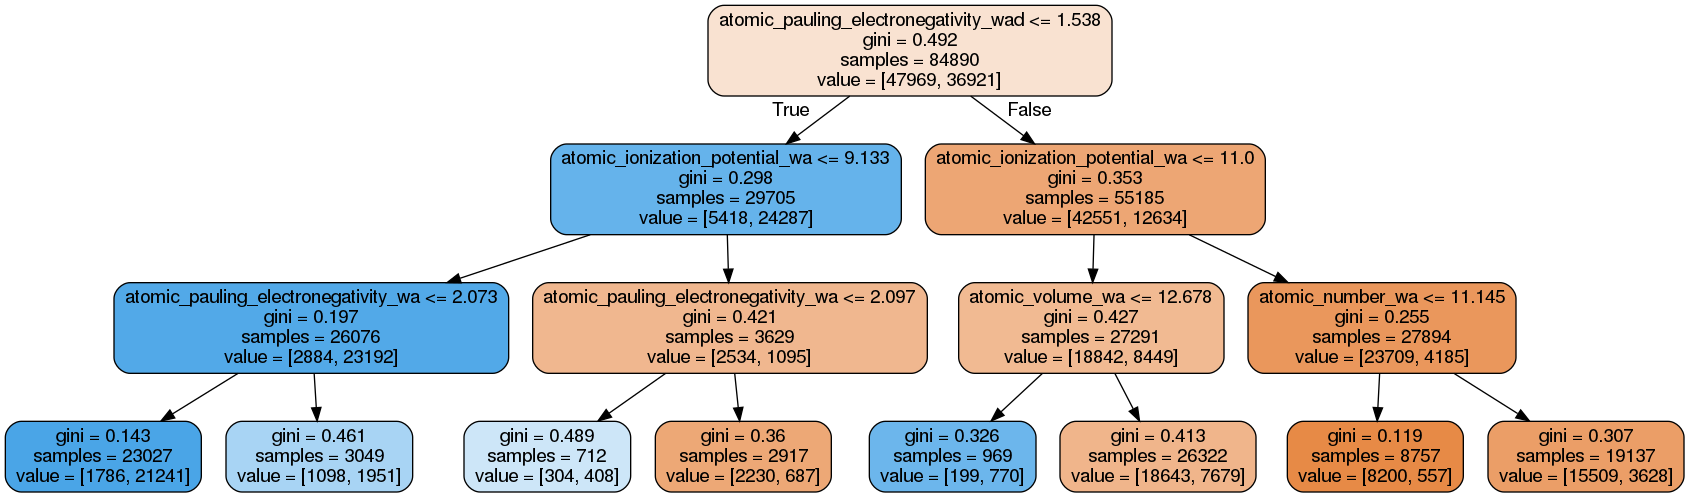

In [21]:
filename = 'data/decision_tree/iris_tree_classifier_depth3'
# Export our tree classifier object to graphviz.
export_graphviz(
    tree_classifier, out_file=filename + '.dot',
    feature_names=train_pred_df.columns,
    rounded=True, filled=True)
call(['dot', '-Tpng', filename + '.dot', '-o', filename + '.png'])
Image(filename=filename + '.png')

In [22]:
# Predict target values in validation set
predicted_target = tree_classifier.predict(test_pred_df)
from sklearn.metrics import accuracy_score
print("Accuracy: %.1f %s " % (100*accuracy_score(test_target_df, predicted_target), """%"""))

Accuracy: 81.2 % 


No surprise our tree model is splitting on the weighted average deviation of electronegativity. Our physics intuition tells us this variable tells us about the ionic bond like character in the compound. The second round of splits looks at ionization potentials which gives us a good idea of how loosely the electrons in the outermost shell is tied to the nuclei.

Let's look how the max depth variable affects our accuracy of classification.

In [23]:
# Find optimal hyperparameter

max_depth_list = list(range(1, 20))
tree_accuracy_list = []
for max_depth in max_depth_list:
    tree_classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    # Fit the new classifier object with maximum depth 3 to our target.
    tree_classifier.fit(X=train_pred_df, y=train_target_df)
    accuracy = accuracy_score(test_target_df, tree_classifier.predict(test_pred_df))
    print(accuracy)
    print('Max depth of %d gives accuracy %s' % (max_depth, str(round(100*accuracy, 2))+"""%"""))
    tree_accuracy_list.append(accuracy)

0.7883428356028837
Max depth of 1 gives accuracy 78.83%
0.8048343777976723
Max depth of 2 gives accuracy 80.48%
0.81237336851529
Max depth of 3 gives accuracy 81.24%
0.8203364274607737
Max depth of 4 gives accuracy 82.03%
0.8233049050558356
Max depth of 5 gives accuracy 82.33%
0.8280638929463318
Max depth of 6 gives accuracy 82.81%
0.834095085520426
Max depth of 7 gives accuracy 83.41%
0.8371106818074731
Max depth of 8 gives accuracy 83.71%
0.8415869575460585
Max depth of 9 gives accuracy 84.16%
0.8436130613014182
Max depth of 10 gives accuracy 84.36%
0.8446025538331056
Max depth of 11 gives accuracy 84.46%
0.8476181501201526
Max depth of 12 gives accuracy 84.76%
0.850351034255289
Max depth of 13 gives accuracy 85.04%
0.8512934080949913
Max depth of 14 gives accuracy 85.13%
0.8519530697827828
Max depth of 15 gives accuracy 85.2%
0.8512934080949913
Max depth of 16 gives accuracy 85.13%
0.8527069688545446
Max depth of 17 gives accuracy 85.27%
0.8518588323988127
Max depth of 18 gives accu

In [24]:
text_param = 'large'
params = {'legend.fontsize': text_param,
  'figure.figsize': (7, 7),
 'axes.labelsize': text_param,
 'axes.titlesize': 'medium',
 'xtick.labelsize': '14',
 'ytick.labelsize': '14'}
plt.rcParams.update(params)

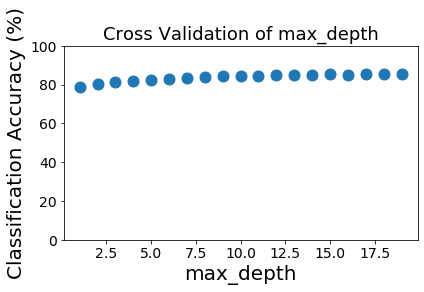

In [25]:
%matplotlib inline
def plot_cross_validation(accuracy_list, hyper_param_list, hyper_param_name, y_lower_lim, y_upper_lim):
    """Plot accuracy score against hyper parameter."""
    fig = plt.figure()
    plt.plot(hyper_param_list, np.multiply(accuracy_list, 100), "o", markersize=11)
    plt.xlabel(hyper_param_name, fontsize = '20')
    plt.ylabel('Classification Accuracy (%)', fontsize = '20')
    plt.ylim(y_lower_lim, y_upper_lim)
    title = 'Cross Validation of ' + hyper_param_name
    plt.title(title, fontsize = '18')
    plt.tight_layout()
    plt.show()

plot_cross_validation(tree_accuracy_list, max_depth_list, 'max_depth', 0, 100)

Hard to see much change in the classification rate with max depth as a hyer parameter.

What about if we zoom in on the region of interest 75% accuracy to 85% accuracy.

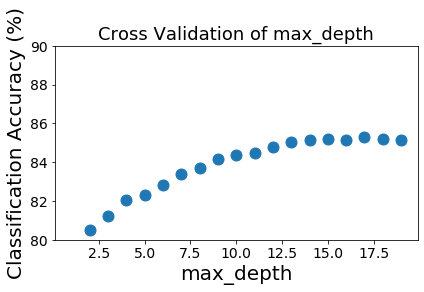

In [26]:
plot_cross_validation(tree_accuracy_list, max_depth_list, 'max_depth', 80, 90)

We note that classification accuracy increases as we grow larger and larger trees by setting the max depth parameter higher and higher until a certain point. At around max_depth equal to 20 we peak drop down and level off.

At this point the tree is no longer able to make very good partitions. It's also possible that at a certain depth the tree reaches a sub-partition with only one datapoint making it impossible to partition this region further to increase purity. Can you think why growing the tree larger could have an adverse effect? Trees are very powerful as they are able to predict non-linear trends well but they suffer from the problem of overfitting. To combat that, cross-validation to find the best hyper parameters is very important.

In many algorithms to grow trees the size of the tree $|T|$ (the depth) is a penalty in the cost function. Meaning the split must award more purity increases that the penalty of having a larger tree.

<a id='learning_curve'></a>
## Plot Learning Curve

We can also look at the learning curve to see a bit more about trees.

I mentioned that trees are greedy algorithms. This means that sometimes we make a split that seems to reward the cost function the most. That is because the algorithm makes the decision at each split and it doesn't foresee what the potential gains further down the tree might be by making this split. This means tree's can be grown quickly but it also means we might make the non-optimal split. Especially if we make the non-optimal split early on in the tree this can have adverse effects.

Let's look at the learning curve below by plotting the training classification accuracy as well as test/validation accuracy as we increase the size of the training dataset.


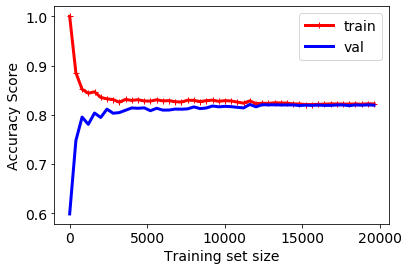

In [27]:
def plot_learning_curves(X_train, X_val, y_train, y_val, max_depth=5):
    """Method developed by Aurelion Geron"""

    train_errors = []
    val_errors = []
    samples_num = []
    for m in range(10, 20000, 400):
        model = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
        model.fit(X_train[:m, :], y_train[:m])
        y_train_predict = model.predict(X_train[:m, :])
        y_val_predict = model.predict(X_val)
        train_errors.append(accuracy_score(y_train[:m], y_train_predict))
        val_errors.append(accuracy_score(y_val, y_val_predict))
        samples_num.append(m)

    plt.plot(samples_num, train_errors, "r-+", linewidth=3, label="train")
    plt.plot(samples_num, val_errors, "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("Accuracy Score", fontsize=14)
    plt.show()

plot_learning_curves(
    X_train=train_pred_df.to_numpy(),
    X_val=test_pred_df.to_numpy(),
    y_train=list(train_target_df),
    y_val=list(test_target_df))

In the learning curve we see the training accuracy score starts at 100%. This is because it is only classifying two data points in the training set since the size is 2 there. As the size grows larger the training data set has more variance and is harder for the tree to classify and the training accuracy goes down until it settles at a fairly constant accuracy.

The validation set accuracy starts off low since we've trained a model on so few data points it is not very good as predicting the data points in the validation set that it has not seen. As the training set size increases the validation accuracy increases. We see we need about 5000 samples in the training set to get an accuracy of 83% in the validation set. Increasing the training set further doesn't help us predict the validation data better.

What about the learning curve for a max depth of 5000?

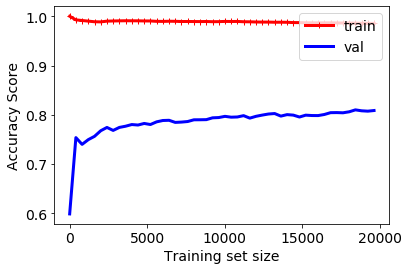

In [28]:
plot_learning_curves(
    X_train=train_pred_df.to_numpy(),
    X_val=test_pred_df.to_numpy(),
    y_train=list(train_target_df),
    y_val=list(test_target_df),
    max_depth = 5000)

In this learning curve we see the training error is much better than the validation error. This is a sign that we are too closely fitting the data in our training set. It is symptomatic of trees that are allowed to grow to large sizes. They often end up putting each training data point in its own partition and overfitting the training data. If there are only a few nodes in the partition, our estimate for the class will not be very good as we're estimating probabilities with very few data points.

<a id='no_scaling'></a>
## No Data Scaling/Centering Required
One nice thing about trees is that they require very little data preparation. We don't have to scale our features to zero mean and a standard deviation of one. In fact the tree doesn't care if we multiply some features by 100 and others by 0.0002. Multiplying our features by these numbers would cause issues in methods like ridge regression where the methods penalize the size of the coefficient. This is why in ridge regression we often center and scale our inputs.

<a id='regression_trees'></a>
# Regression Trees

We've seen several examples of using trees to classify data what about regression problems where we are not trying to estimate the class but rather to estimate a value.

Trees have found much success in regression problems including the material science domain. A well known paper is from Prof. Wolverton's group that can be found [here](https://www.nature.com/articles/npjcompumats201628?report=reader#Sec14). In this paper the authors try to estimate the volume per atom for binary compounds. We'll use the data sets from the paper and see how well we can do. This data can also be found in NOMAD. Andreas has again helped us out with the parsing and we can load the parsed data from a csv file he has given us.

In [29]:
import pandas as pd
# The Materials Project data has been conveniently
# saved as a csv for us.
mat_proj_filename = 'data/decision_tree/Handson_OQMD_data_volperat.csv'

# We read the data into a pandas
# dataframe. We use pandas read_csv() method on the filename.
dataframe = pd.read_csv(mat_proj_filename)

# Preview the first 5 lines of the loaded data 
dataframe.head()

compound  vol_per_atom  rel_stoich_wa  rel_stoich_wad  atomic_volume_wa  \
0      Mg1       22.9639            1.0             0.0             14.00   
1      Kr1       41.4146            1.0             0.0             27.99   
2      Na1       32.9826            1.0             0.0             23.78   
3      Pd1       15.2088            1.0             0.0              8.56   
4      Fe1       11.5973            1.0             0.0              7.09   

   atomic_volume_wad  atomic_rs_max_wa  atomic_rs_max_wad  atomic_rp_max_wa  \
0                0.0      1.330300e-10                0.0      1.899100e-10   
1                0.0      7.056000e-11                0.0      8.180000e-11   
2                0.0      1.714400e-10                0.0      2.579300e-10   
3                0.0      1.405600e-10                0.0      2.143800e-10   
4                0.0      1.319100e-10                0.0      1.943700e-10   

   atomic_rp_max_wad  atomic_rd_max_wa  atomic_rd_max_wad  atomic_number_wa  \
0                0.0      5.619300e-10                0.0              12.0   
1                0.0      2.170000e-11                0.0              36.0   
2                0.0      8.453600e-10                0.0              11.0   
3                0.0      5.822000e-11                0.0              46.0   
4                0.0      3.793000e-11                0.0              26.0   

   atomic_number_wad  atomic_ionization_potential_wa  \
0                0.0                           7.645   
1                0.0                          14.000   
2                0.0                           5.138   
3                0.0                           8.337   
4                0.0                           7.902   

   atomic_ionization_potential_wad  atomic_pauling_electronegativity_wa  \
0                              0.0                                 1.31   
1                              0.0                                 3.00   
2                              0.0                                 0.93   
3                              0.0                                 2.20   
4                              0.0                                 1.83   

   atomic_pauling_electronegativity_wad  atomic_r_covalent_wa  \
0                                   0.0                  1.41   
1                                   0.0                  1.16   
2                                   0.0                  1.66   
3                                   0.0                  1.39   
4                                   0.0                  1.32   

   atomic_r_covalent_wad  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0

What are these features (columns)?

In [30]:
train_df, test_df = train_test_split(
    dataframe, test_size=0.2, random_state=1)

train_pred_df = train_df.drop(columns=['compound', 'vol_per_atom'])
test_pred_df = test_df.drop(columns=['compound', 'vol_per_atom'])

train_target_df = train_df['vol_per_atom']
test_target_df = test_df['vol_per_atom']
print(len(list(train_target_df)))

277761


<a id='choosing_constants'></a>
## Choose Best Constant Estimate in Each Region

Let's discuss how regression trees work.

We have $p$ inputs and a target (response) for each of our $N$ observations. That is $(x_{i}, y_{i})$ for $i = 1, 2, ..N$ with $x_{i}$ being a vector $(x_{i1}, x_{i2},..., x_{iN})$. The algorithm here will decide which variables (input features) to split on and where to split them (split points).

Imagine we have a partition into $M$ different regions $R_{1}, R_{2}, ..., R_{M}$ of space. At each region of space we will model the target (response) with a constant $c_{m}$ that is specific to each region. Note some tree algorithms don't use a constant but most do.

The predicted model can then be recast into a single equation as:

$$ f(x_{i}) = \sum \limits _{m=1} ^{M} c_{m} I(x_{i} \in R_{m}) $$

You might ask what we should choose as our constant $c_{m}$ for each region. This depends on what our minimization strategy is. Most commonly, one is trying to reduce the sum of squares (mean squared error minimization ends up being the same task) which is defined as.

$$ Cost = \sum \limits _{i=1}^{i=N} (y_{i} - f(x_{i}))^2 $$

If we choose $c_{m}$ to be a constant (which is the standard procedure in trees), what should we choose? Let's rewrite the cost as $J$ being a function of $c_{m}$.

$$ J(c_{m}) = \sum \limits _{i=1}^{i=N} (y_{i} - \sum \limits _{m=1} ^{M} c_{m} I(x_{i} \in R_{m}))^2 $$

Now let's find the c_{m} that minimizes this equation. We take the derivative of the cost $J(c_{m})$ with respect to $c_{m}$.

$$ 0 = \frac{dJ(c_{m})}{dc_{m}} = (2)*\sum \limits _{i=1}^{i=N} (y_{i} - \sum \limits _{m=1} ^{M} c_{m} I(x_{i} \in R_{m}))*(-1) $$

Now we can move the $y$ terms to one side and the $c_{m}$ terms to one side of the equation.

$$ (2)*\sum \limits _{i=1}^{i=N} y_{i} = (2)*\sum \limits _{i=1}^{i=N} \sum \limits _{m=1} ^{M} c_{m} I(x_{i} \in R_{m}) $$

Ok great. But now we need to remember what is happening with that indexing function $I(x_{i} \in R_{m})$ we recall that is $1$ if and only if $x_{i}$ in $R_{m}$. So let's go ahead and solve the above equation for a specific region $R_{m'}$. The right hand side becomes.

$$ 2*\sum \limits _{i=1}^{i=N} c_{m'} *(1) = 2*N*c_{m'}$$

The left hand side becomes a smaller summation. Now we're minimizing the cost function for the region $R_{m}$. The region $R_{m}$ only contains $y_{i}$ points from the pairings $(y_{i}, x_{i})$ where the $x_{i}$ is in $R_{m}$. So we have to condition (specify) that the $y$ points on the left hand side correspond to pairings where the $x_{i}$'s belong to $R_{m}$. We can write in math below:

$$ (2)*\sum \limits _{i=1}^{i=N} (y_{i} | x_{i} \in R_{m'}) $$

Perfect. Now let's set the two sides equal and solve for $c_{m}$

$$ c_{m'} = \frac{1}{N} \sum \limits _{i=1}^{i=N} (y_{i} | x_{i} \in R_{m'}) $$

This equation tells us that the optimal constant to choose for each $c_{m}$ is simply the average of the target in the region $R_{m}$. Using the average (mean) to minimize the sum of squares is a well known result from statistics - [proof](https://math.stackexchange.com/questions/1352726/minimizing-a-function-sum-of-squares/1352735). We have simply used this fact and applied it to our partition/region based problem.

<a id = 'best_partition'></a>
## Find the Best Binary Partition

Now we need to also ask ourselves what is the best binary partition of the dataset. We know once we've partitioned our data that we can choose the constant estimate for the target in each region to be the average of the target in that region. We have not yet answered the question - how do we make those partitions in the first place?

Finding the best binary (2 children for each split) partition of the feature space is generally computationally infeasible. We would have to try each split on every variable and then compare all the synthesized trees. Instead, the applied statistics community normally approaches this problem using a greedy algorithm. Greedy algorithms build solutions piece by piece where they always choose the next piece which offers the most obvious and immediate benefit.

Starting with all of the data, consider a variable to split on, let's call this variable $j$. We have to choose a split boundary/threshold/point for this variable, let's call the split point $s$.

After the split we end up with two partitions (half-planes).

$$ R_{1}(j,s) = \{X | X_{j} \leq s\}$$
$$ R_{2}(j,s) = \{X|X_{j} > s\}$$

Therefore, the task is to find the optimal $j$ and $s$ that minimize the sum of squares.

$$ min_{j,s} [ min_{c1} \sum  \limits _{x\in R_{1}(j,s)} (y_{i} - c_{1})^2 + min_{c2} \sum \limits _{x_{i} \in R_{2}(j,s)} (y_{i} - c_{2})^2  ] $$

For each choice of $j$ and $s$ we know that the best constant $c_{1}$ and $c_{2}$ is simple the mean of the target $y_{i}$ in those regions.

$$ c_{1} = average(y_{i} | x_{i} \in R_{1}(j,s))$$
$$c_{2} = average(y_{i} | x_{i} \in R_{2}(j,s)) $$

For each variable $j$ we could split on we can find the best split points $s$ quickly by solving this optimization problem by substituting the value of $c_{1}$ and $c_{2}$ and performing gradient descent. In other words we fix $j$ and then we scan possible split points substituting the corresponding $c(j,s)_{1}$ and  $c(j,s)_{2}$ values to find the value of the cost (minimization problem) at each split point $s$. This is a numerical solution not an analytical solution but it can be done quite fast allowing us to find the best $(j,s)$ pair. Once we have the best pair, we have the best split.

We then partition the data into the two resulting regions and repeat the process on each of the two regions.

<a id='train_regressor'></a>
## Train Regressor
We made it through the math forest! yes, now let's build a regression tree on this data.

In [31]:
# Import Decision Tree Regression Module from Python
# We will use this class to build our tree.
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

max_depth_list = list(range(2,26,2))
for max_depth in max_depth_list:
    regressor = DecisionTreeRegressor(max_depth = max_depth, random_state=0)
    regressor.fit(train_pred_df, train_target_df)
    # Get predictions from the tree. This will output a list
    # of target predictions f(x).
    predictions_list = regressor.predict(test_pred_df)
    # Calculate the mean squared error between predictions
    # and target. Our test_target_df is a dataframe and not
    # a list. We transform it into a list using python's list()
    # function.
    mse_metric = mean_squared_error(list(test_target_df), predictions_list)
    rmse_metric = np.sqrt(float(mse_metric))
    print('The Root Mean Squared Test Error for Depth %d is: %.3f' % (max_depth, rmse_metric))


The Root Mean Squared Test Error for Depth 2 is: 5.756
The Root Mean Squared Test Error for Depth 4 is: 4.048
The Root Mean Squared Test Error for Depth 6 is: 3.530
The Root Mean Squared Test Error for Depth 8 is: 3.434
The Root Mean Squared Test Error for Depth 10 is: 3.170
The Root Mean Squared Test Error for Depth 12 is: 3.022
The Root Mean Squared Test Error for Depth 14 is: 2.934
The Root Mean Squared Test Error for Depth 16 is: 2.900
The Root Mean Squared Test Error for Depth 18 is: 2.882
The Root Mean Squared Test Error for Depth 20 is: 2.885
The Root Mean Squared Test Error for Depth 22 is: 2.888
The Root Mean Squared Test Error for Depth 24 is: 2.893


We can visually see that a depth of around 12 gives us an RMSE of 3 Angstroms cubed. Larger trees seem to give marginal gains here.

Let's look at well the depth 12 tree does on our data.



In [32]:
max_depth = 12
regressor = DecisionTreeRegressor(max_depth = max_depth, random_state=0)
regressor.fit(train_pred_df, train_target_df)
# Get predictions from the tree. This will output a list
# of target predictions f(x).
predictions_list = regressor.predict(test_pred_df)

Alright, we collected the predictions of our model for our test data. To evaluate how well our model is doing let's compare the tree's predictions to the real test data volume per atom. First let's plot the error in our tree prediction and real test data vs. the real test data. This will give us an idea of what true volumes we are badly mispredciting with our depth 12 tree.

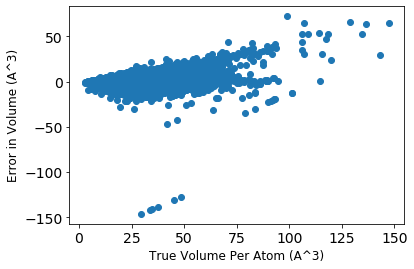

In [33]:
error_list = list(test_target_df) - predictions_list
plt.plot(list(test_target_df), error_list, 'o')
plt.xlabel('True Volume Per Atom (A^3)')
plt.ylabel('Error in Volume (A^3)')
plt.show()

We also plot the true test data results vs. the predictions in a graph below. If the model was perfect at predicitng the real test values we would expect all of the data to fall on the diagonal line. The diagonal line is the test_data = prediction line. We see there is signficant deviation from this line for some data points.

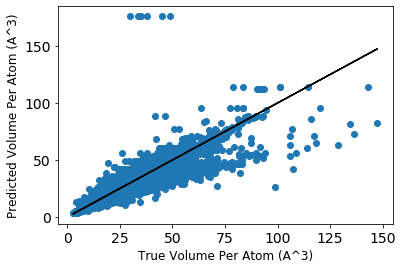

In [34]:
plt.plot(list(test_target_df), predictions_list, 'o')
plt.xlabel('True Volume Per Atom (A^3)')
plt.ylabel('Predicted Volume Per Atom (A^3)')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
plt.show()

<a id='ensemble_methods_theory'></a>
# Ensemble Methods Theory

We don't expect everyone to finish with the above tutorial. If you are interested in further topics, the next few sections expand further into the world of statistical learning. This information builds upon using decision trees and tries to fix some of their flaws. But, in case you are interested and want to learn on your own we include the topic of ensemble methods here.

Trees unfortunately suffer from overfitting. They use piecewise constant functions to approximate the underlying distribution. If you'd like to learn more about the theory behind over-fitting and the tradeoff in a model between bias and variance I recommend the lecture and notes by Prof. Weinberger at Cornell [here](https://www.youtube.com/watch?v=zUJbRO0Wavo&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=19).


One crucial point is that we can often imagine a situation where in our dataset we could have two data points $(x_{1},y_{1})$ and $(x_{2}, y_{2})$ where $x_{1} = x_{2}$ (two feature vectors are the same) but $y_{1} != y_{2}$ (the associated targets are not the same). An example could be trying to estimate housing prices based on square footage. Two houses of the same square footage have different prices. In such a situation, our learning task has a tough time. Should it predict $y_{1}$ if it sees $x_{1} = x_{2}$ as input or should it predict $y_{2}$. Often in these cases we're trying to minimize the mean squared error (or RMSE) and it's best in this case to estimate the mean value of $y$ for a given $x$. More formally for a given feature vector $x$ there is distribution of $y$ target values $P(y | x = x')$. We are trying to estimate the mean value of $P(y | x = x')$.

We can then define the target to be the mean of y given x. where $x$ our feature vector live in $\mathbb{R}^d$ as

$$ \bar{y}(\mathbf{x}) = E_{y \vert \mathbf{x}} \left[Y\right] = \int\limits_y y \, \Pr(y \vert \mathbf{x}) \partial y. 
$$

We can call the variance in $y$ for a given $x$ the irreducible error or noise. Since our model is simply trying to find the mean value of y, it can't do any better than estimate the mean. When it predicts the mean value of y given x we still have some loss that depends on the standard deviation (variance) of y given x.

Our tree model also has some other sources of error. What about two trees trained on two datasets that we sample randomly from our target distribution. Often the two trees will be quite different and predict different results (especially if we let them grow to large depths where few data points make up a leaf region). We call this the variance of our model. 

The last source of error is that even when training the same type of model, in our case a tree, multiple times with different sources of data, each trained tree misses the target. The mean (where we repeat the training process for a new tree with new data) error between the target and the tree is called the bias of the model (tree model in our case).

The equation that Prof. Weinberger derives (we leave it out here) is one of the most important equations in applied statistics / statistical learning.

$$\underbrace{E_{\mathbf{x}, y, D} \left[\left(h_{D}(\mathbf{x}) - y\right)^{2}\right]}_\mathrm{Expected\;Test\;Error} = \underbrace{E_{\mathbf{x}, D}\left[\left(h_{D}(\mathbf{x}) - \bar{h}(\mathbf{x})\right)^{2}\right]}_\mathrm{Variance} + \underbrace{E_{\mathbf{x}, y}\left[\left(\bar{y}(\mathbf{x}) - y\right)^{2}\right]}_\mathrm{Irreducible Error/Noise} + \underbrace{E_{\mathbf{x}}\left[\left(\bar{h}(\mathbf{x}) - \bar{y}(\mathbf{x})\right)^{2}\right]}_\mathrm{Bias^2}
$$

Some notes about notation. $h$ is our model regressor. It depends on the training dataset $D$ we are training on. In this equation the regressor is always the same type of model. We're trying to quantify the error of using this type of model.

$ h_{D} = Model(D) $ 

Once the model has been trained on the training dataset $D$ it's able to predict. We quantify the error of the model by looking at a sample test datapoint $(x,y)$ (feature, target).

Trees have low bias. They're able on average to do very well. They are based off a greedy algorithm (choose the best split at an instant and don't think about if this split makes sense in regards to splits made further down the tree). As a result, trees trained on slightly different data often look quite different. This means trees have high variance. They are prone to overfit our training data. To reign in the wildness of trees we can simply train many trees and average their outputs.

This idea was inspired by a principle called bagging. We train many trees on our training dataset. Since we don't have different datasets, we only have our one training dataset, we sample from it without replacement (bootstrapping).

We then use a committee system where each tree votes what the target should be and we average the result. This idea is called bagging or bootstrap aggregation. It's used to reduce the variance of an estimated prediction function.

The essential idea in bagging is to average many noisy but approximately unbiased models, and hence reduce the variance. Trees are ideal candidates for bagging, since they can capture complex structures in the data, and if grown sufficiently deep, have relatively low bias (error). Since trees are notoriously noisy, they benefit from the averaging.


The statistical principle behind this is: an average of $B$ independently identically distributed (iid) variables each with variance $\sigma^2$ has variance $\frac{1}{B}\sigma^2$. When we grow our trees in the committee they are unfortunately not statistically independent from one another but we try to make them as independent as possible by the following rule.

We'll train bagging classifiers further down.

<a id='random_forests'></a>
# Random Forests
There's another method that is actually used more often for regression and we'll start looking at our regression problem of predicting Angstroms cubed. We'll again bootstrap our data (sample from our training data with replacement). This will cause some trees to look different. But, we want even more different trees so that each one captures something different in our underlying distribution (target).We'd rather have a committee of trees that capture different interaction structures in the data. To do so, we can build each tree in the committee using a random subset of features. So rather than allowing the tree to partition a region by splitting on potentially all features, we limit the allowed feature number to a subset of the total features. The end effect is many different trees in the committee.

Before each split, we select $m$ $\leq$ $p$ of the input variables at random as candidates for splitting. This is called the random forest method.

Let's start with the random forest regressor on our volume data. Note you can also use random forest classification.

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

random_regressor = RandomForestRegressor(
    n_estimators=50, max_depth = 30, n_jobs=-1, random_state=0)
random_regressor.fit(train_pred_df, train_target_df)
predictions = random_regressor.predict(test_pred_df)
rmse = np.sqrt(mean_squared_error(list(test_target_df), predictions))
print('RMSE is %.3f' % rmse)
print('R2 score is: %.3f' % r2_score(list(test_target_df), predictions))

RMSE is 2.785
R2 score is: 0.900


Awesome. So this time we built trees with max depth of 30. When we did that previously we noticed our trees were overfitting and actually doing worse than trees of depth 12-14. Now since we are using a committee of trees that are built using different subsets of features we are less prone to overfitting even when using a committee of large trees.


Let's look at how the number of estimators affects our test error.

In [36]:
number_of_trees_list = list(range(2, 32, 2))
rmse_list = np.zeros(len(number_of_trees_list))
i = 0
for num_trees in number_of_trees_list:
    
    random_regressor = RandomForestRegressor(
        n_estimators=num_trees,
        max_depth = 30,
        max_features = 10,
        min_samples_split = 40,
        n_jobs=10, random_state=0)
    random_regressor.fit(train_pred_df, train_target_df)
    predictions = random_regressor.predict(test_pred_df)
    rmse = np.sqrt(mean_squared_error(list(test_target_df), predictions))

    rmse_list[i] = rmse
    print('For %d trees we get rmse: %.3f' % (num_trees, rmse))
    i += 1

For 2 trees we get rmse: 2.888
For 4 trees we get rmse: 2.731
For 6 trees we get rmse: 2.644
For 8 trees we get rmse: 2.635
For 10 trees we get rmse: 2.593
For 12 trees we get rmse: 2.563
For 14 trees we get rmse: 2.590
For 16 trees we get rmse: 2.607
For 18 trees we get rmse: 2.590
For 20 trees we get rmse: 2.563
For 22 trees we get rmse: 2.578
For 24 trees we get rmse: 2.556
For 26 trees we get rmse: 2.539
For 28 trees we get rmse: 2.551
For 30 trees we get rmse: 2.537


We see the more trees we use in our committee the better our predictions on our test data set. We also see marginal gains after using 12 trees. Feel free to change the parameters we've used in our trees to see if you can get a better result.

<a id='cross_validation'></a>
# Cross Validation - Hyperparameter Search

The tree models we use all have multiple hyper parameters. To choose the optimal combination of hyper-parameters we perform k-fold cross validation on a grid search. To choose the best max depth hyper parameter for a tree we could vary the max depth hyper parameter and grow a tree on the training data with this max depth and look at the RMSE or misclassification error on the test set. This strategy is a simple one but it's not great because we end up finding the best model that works for the test data set. Sometimes this test data set is small and ideally we'd like to verify the model on data that the model has never touched at all. If we compare the test results to find the best parameter we've used the test data.

So instead we can split our data into let's say 10 partitions/folds. We then choose one of the partitions to be the test set and the rest of the data to be training data. We then calculate our test error. Now repeat the procedure but choose a different one of the ten partitions to be our test partition (test fold). We can choose 10 distinct folds to be the test fold. We train on the data that is not in the test fold. At the end we simply average results predicting on the distinct test folds. This is a good strategy because a single outlier can affect the test results greatly and by averaging results from different distinct test folds we smoothen these numbers.

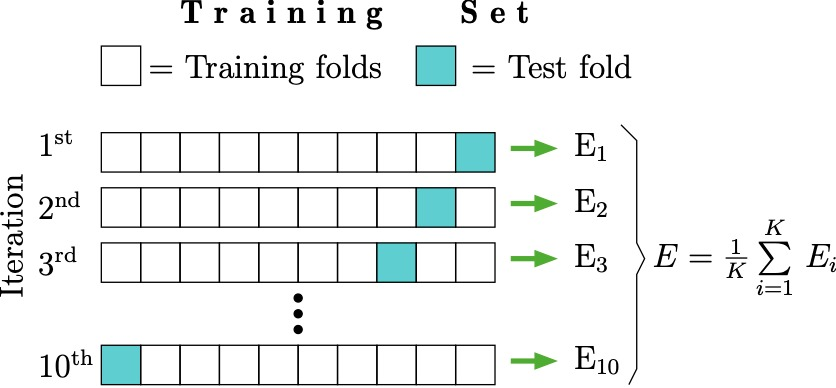

In [37]:
Image(filename='assets/decision_tree/cv.jpeg', width=500)

<a id='grid_search'></a>
## Grid Search
Grid search means we create a grid of combinations of hyper-parameters and then try every pairing in the grid. For a simple tree we can control the minimum number of samples $g$ in a leaf node (this will prevent a split that leaves less than $g$ samples in a partition). We can also control the max depth of the tree. We choose different values of max depth that we want to try and different values of min. number of samples in a leaf node. We then try each possible combination of the two hyper-parameters. This strategy is used for more than 2 hyper parameters.

We use [gridsearchcv()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) by sklearn. Note this next section will take some time as it is trying all the possible combinations in the parameter grid. Feel free to make this parameter grid larger. You might find an even better possible combination. Since we'd like this to run fast for the tutorial we've made the grid quite small, ideally you should use a large grid that is sparse and then zoom in (add new param grid points) on good results.

Note, this grid search can take some time (>5 minutes on a laptop).

In [38]:
from sklearn.model_selection import GridSearchCV
# Choose the random Forest Regressor regressor as our model.
model = RandomForestRegressor(random_state=0)
# Create a parameter grid. We will go over
# each possible combination of allowed parameters in the grid.
param_grid = {
    'min_samples_split': [20, 100],
    'max_depth': [5, 20],
    'max_features': [5, 10],
    'n_estimators': [20, 50]
    }
# Create a grid search cross validation model.
# It performs 5 fold cross validation by default.
cross_val_obj = GridSearchCV(
    model, param_grid = param_grid, n_jobs=4, return_train_score=True)
# Perform the cross validation using our train data.
cross_val_obj.fit(train_pred_df, train_target_df)
# Select the trained tree that did the best in the cross
# validation.
best_regressor = cross_val_obj.best_estimator_
print('The model with the best R2 from CV is %.3f' % cross_val_obj.best_score_)
print('The best param(s) for the CV search is/are %s' % cross_val_obj.best_params_)

# Now test this model on our validation dataset which haven't yet exposed to our model.

predictions_list = cross_val_obj.predict(test_pred_df)
rmse = np.sqrt(mean_squared_error(predictions_list, list(test_target_df)))
print(' The root mean squared error for the regressor found by CV is: %.3f' % rmse)


The model with the best R2 from CV is 0.891
The best param(s) for the CV search is/are {'max_depth': 20, 'max_features': 10, 'min_samples_split': 20, 'n_estimators': 50}
 The root mean squared error for the regressor found by CV is: 2.646


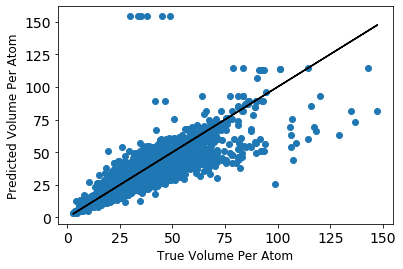

In [39]:
plt.plot(list(test_target_df), predictions_list, 'o')
plt.xlabel('True Volume Per Atom')
plt.ylabel('Predicted Volume Per Atom')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
plt.show()

In a more realistic setting we would make our grid search larger to find the best combination of random forest hyperparameters. At the moment this grid search didn't yield better results simply because the range of parameters is too small. A larger search will take longer time but it can be parallelized (each combination of setting will be a seperate parallel task) on a computing cluster to run in a reasonable amount of time.

<a id='feature_importance'></a>
# Feature Importance in Random Forests

It's one thing to be able to model our target well. It's another thing to understand a bit more about our dataset. We'd like to know which features are important in our random forest.

In [40]:
for name, score in zip(list(train_pred_df.columns), best_regressor.feature_importances_):
    print(name, score)

rel_stoich_wa 0.0070603676053230735
rel_stoich_wad 0.010256642042111299
atomic_volume_wa 0.3202417270012869
atomic_volume_wad 0.022581992857773747
atomic_rs_max_wa 0.0
atomic_rs_max_wad 0.0
atomic_rp_max_wa 0.0
atomic_rp_max_wad 0.0
atomic_rd_max_wa 0.0
atomic_rd_max_wad 0.0
atomic_number_wa 0.030474123908880667
atomic_number_wad 0.008496903024676782
atomic_ionization_potential_wa 0.05685133080116065
atomic_ionization_potential_wad 0.012002564815261685
atomic_pauling_electronegativity_wa 0.14234287005589433
atomic_pauling_electronegativity_wad 0.01639132714209765
atomic_r_covalent_wa 0.36085772856547726
atomic_r_covalent_wad 0.012442422180056058


Let's make this feature importance data more easy to look at. We can follow matplotlib's (plotting library in python) guide to bar plots [here](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barh.html)


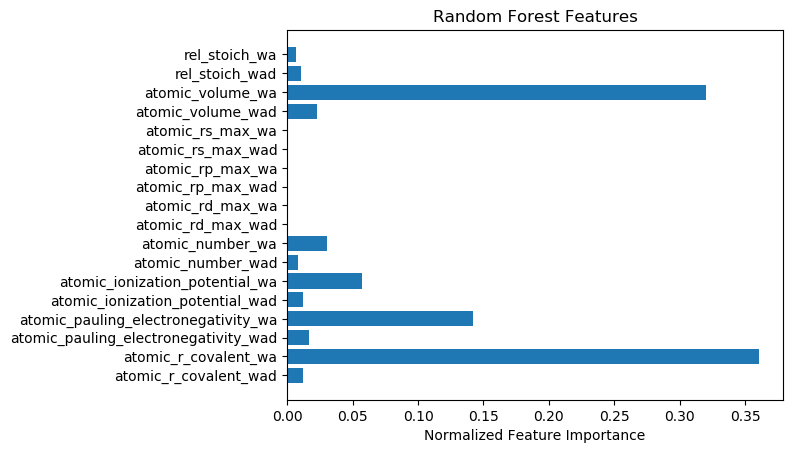

In [41]:
# Let's make this look nicer

# We first convert our feature importances and feature column names
# into a dictionary.
feature_dict = dict(zip(list(train_pred_df.columns), best_regressor.feature_importances_))

plt.rcdefaults()

fig, ax = plt.subplots()
y_pos = np.arange(len(list(feature_dict.keys())))

ax.barh(list(feature_dict.keys()), list(feature_dict.values()))
ax.set_yticks(y_pos)
ax.set_yticklabels(list(feature_dict.keys()))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Normalized Feature Importance')
ax.set_title('Random Forest Features')
plt.show()

What do these feature importances mean?

Let's first think about classification trees. When we perform a split in a classification tree on a variable it means the gini purity of the two child nodes is greater than in the parent node. We've increased the gini purity. We can sum up the gini purity increase of each split in the tree for each variable. Variables that are split on often and who have splits that increase the gini purity the most are then the most important features.

Here's a definition from Prof. Brieman, the inventor of random forests - 'Every time a split of a node is made on variable m the gini impurity criterion for the two descendent nodes is less than the parent node. Adding up the gini decreases for each individual variable over all trees in the forest gives a fast variable importance that is often very consistent with the permutation importance measure.'

Similarly for regression trees, we can add up all the sum of squares increases for each individual variable over all trees in the forest. This is what is shown above.

The feature importances gives us an insight into the physics at play. We can see what features allow us to better predict the volume per atom of a compound. We see the atomic covalent bond distance (weighted average), the atomic volume (weighted average), and the atomic pauling electronegativity (weighted average) and the most important features. This comes as no surprise as we know the covalent bond distance gives us a good idea of the spacing between atoms, as does the atomic volume. The average electronegativity of the compound helps us understand how the compound might deviate from the sum of atomic volume.

<a id='bagging_classifier'></a>
# Bagging Classifier

We mentioned bagging earlier in the ensemble methods theory. We simply sample our training dataset with replacement to get many synthesized datasets. We then train a tree on each of these synthetic datasets. We then have many trees and each one gets one vote in a committee, where the majority decides at the end.

Note: this idea of bootstrapping (sampling with replacement) to form new datasets works well when you have a large training dataset that is representative of the underlying distribution. If you only have 30 data points, it is likely not too helpful to try this technique. Read more about bootstrapping [here](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))

Let's work again on our previous example of classifying materials as metals / non-metals.

Let's see if we can bag many trees created on bootstrapped datasets and do better than using a single tree.

We'll use the [bagging classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) from sklearn.

In [42]:
import pandas as pd
# In case you need to reload the data we looked at earlier.
# You can do so running this cell.
mat_proj_filename = 'data/decision_tree/Handson_metal_vs_nonmetal_data.csv'

# We read the data into a pandas
# dataframe. We use pandas read_csv() method on the filename.
dataframe = pd.read_csv(mat_proj_filename)

In [43]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    dataframe, test_size=0.2, random_state=1, stratify=dataframe['is_metal'])
train_target_df = train_df['is_metal']
test_target_df = test_df['is_metal']
train_pred_df = train_df.drop(columns=['is_metal', 'compound'])
test_pred_df = test_df.drop(columns=['is_metal', 'compound'])

In [44]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


# Note making max samples a float makes it a ratio
# the training data use to train trees.
# Using an int would train on that number of sampled
# datapoints.
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=10), n_estimators=10,
    max_samples=1.0, bootstrap=True, n_jobs=-1)

bagging_clf.fit(X=train_pred_df, y=train_target_df)


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

In [45]:
# Let's get the accuracy
# Predict target values in validation set
predicted_target = bagging_clf.predict(test_pred_df)
from sklearn.metrics import accuracy_score
print("Accuracy: %.1f %s " % (100*accuracy_score(test_target_df, predicted_target), """%"""))

Accuracy: 85.4 % 


Accuracy is not great. But we haven't done much so far. Let's see how we might better analyze a bagging classifier that is made of multiple trees and then go on to try to improve the performance.

We'll first print out the number of nodes in each tree in this collection of trees (ensemble of trees).

In [46]:
# Let's get an idea of what this bagged classifier looks like.
for tree_in_bag in bagging_clf:
    print(tree_in_bag.tree_.node_count)

1123
1039
1043
1173
1183
1099
1111
1059
1093
1129


We can also save images of each tree in the ensemble. We'll display the first tree here.

Note that with a depth of 10 you don't see much in this tree.

1st Classifier


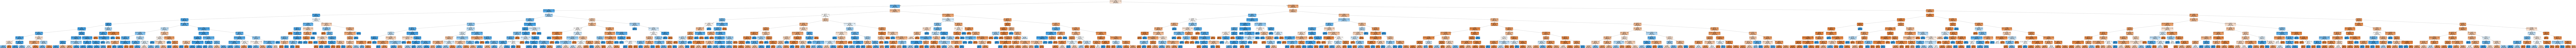

In [47]:
from subprocess import call
from IPython.display import Image
from sklearn.tree import export_graphviz
# We can also loop over the trees in the bagged data.
# And Display them using Ipython.
cnt = 1
for tree in bagging_clf:
    export_graphviz(
        tree, out_file='data/decision_tree/' + str(cnt)+'_tree.dot',
        feature_names= train_pred_df.columns,
        rounded=True, precision=4, node_ids=True,
        proportion=True,filled=True)
    
    call(['dot','-Tpng','data/decision_tree/' + str(cnt)+'_tree.dot','-o','data/decision_tree/' + str(cnt)+'_tree.png'])
    cnt += 1

print('1st Classifier')
# Show the first classifier (to see the others you just change the value of classifier_num)
classifier_num = 1;
Image(filename='data/decision_tree/' + str(classifier_num)+'_tree' + '.png')

We now have an extra number of hyperparameters. What fraction of the original data should we learn on? Let's leave that at 100%. But what about the number of estimators (trees) to use? Let's look at the learning curve here. To make things run faster we'll fix the max depth of each estimator to be 12. You can change the number of estimators at the bottom of this next block of code. Change value of n_estimators in plot(learning_curves) called at the bottom.

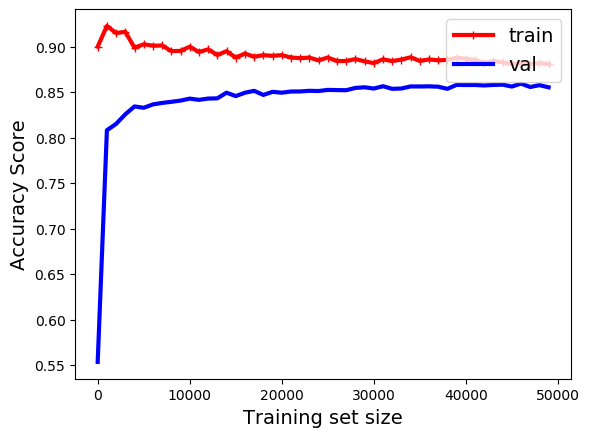

In [48]:
def plot_learning_curves(X_train, X_val, y_train, y_val, n_estimators):
    """Method inspired by Aurelion Geron, note here n_esimators is a input param."""

    train_errors = []
    val_errors = []
    samples_num = []
    for m in range(10, 50000, 1000):
        model = BaggingClassifier(
            DecisionTreeClassifier(max_depth=12, random_state=0),
            n_estimators=n_estimators,
            max_samples=0.5, bootstrap=True, n_jobs=-1)
        model.fit(X_train[:m, :], y_train[:m])
        y_train_predict = model.predict(X_train[:m, :])
        y_val_predict = model.predict(X_val)
        train_errors.append(accuracy_score(y_train[:m], y_train_predict))
        val_errors.append(accuracy_score(y_val, y_val_predict))
        samples_num.append(m)

    plt.plot(samples_num, train_errors, "r-+", linewidth=3, label="train")
    plt.plot(samples_num, val_errors, "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("Accuracy Score", fontsize=14)
    plt.show()

# Plot the learning curve for using 100 estimators. Change this number an 
plot_learning_curves(
    X_train=train_pred_df.to_numpy(),
    X_val=test_pred_df.to_numpy(),
    y_train=list(train_target_df),
    y_val=list(test_target_df),
    n_estimators=10)

The training dataset does quite better than the validation set for 10 estimators. This suggests we might be overfitting.

Let's unleash the power of bagging and use 500 estimators and see how well we do. This might take some time to run (>3 minutes on a latpop). Note in general we need to do cross validation to find the best hyper parameters but this gives you an idea of how well we can do.

In [49]:
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=20), n_estimators=500,
    max_samples=1.0, bootstrap=True, n_jobs=-1)

bagging_clf.fit(X=train_pred_df, y=train_target_df)

# Let's get the accuracy
# Predict target values in validation set
predicted_target = bagging_clf.predict(test_pred_df)
from sklearn.metrics import accuracy_score
print("Accuracy: %.1f %s " % (100*accuracy_score(test_target_df, predicted_target), """%"""))

Accuracy: 88.2 % 


We get an accuracy that is now 88.2% This is a great improvement from our individual tree efforts.

<a id='important_topics_not_covered'></a>
# Important Topics Not Covered

One topic we've omitted due to time constraints is that of pruning. This is the idea of building your tree out until there are no more splits that minimize purity for classification or rmse for regression. You then start from the bottom of your tree and remove splits that turned out to be not so helpful. You end up finding the sub-tree that minimizes the rmse/gini purity subject to a cost on the size of the tree. In case you're interested [here](https://www.coursera.org/lecture/ml-classification/optional-pruning-decision-trees-to-avoid-overfitting-qvf6v) is a lecture from University of Washington on the topic.

Another topic is [gradient boosted trees](https://en.wikipedia.org/wiki/Gradient_boosting). In this method we fit one tree and calculate the error of this tree. We then fit another different tree to the error of the first tree. In this way we try to continually by adding subsequent trees at each step minimize the overall error step by step.